In [1]:
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from matplotlib.font_manager import FontProperties

In [2]:
item_list_file = 'MUCH_meun.txt'
label = None

n_nagsampling = 1
embedding_size = 8
epoch = 10000
lr=3e-2

In [3]:
item_list = []
with open(item_list_file) as f:
    for i in f.readlines():
        temp = i.strip('\n').split()
        item_list.append(temp)
if label is None:
    label = []
    for i , j in enumerate(item_list):
        label.extend([i]*len(j))

In [4]:
postive = []
negtive = []

for index, i in enumerate(item_list):
    sampling_index = list(range(len(item_list)))
    sampling_index.remove(index)
    
    for j in range(len(i)):
        for k in range(len(i)):
            if j != k:
                postive.append((i[j],i[k]))
                neg_items = []
                for idx in sampling_index:
                    negative_item = random.choices(item_list[idx], k=n_nagsampling)
                    neg_items.extend(negative_item)
                negtive.append(neg_items)

In [5]:
item2idx = {}
index = 0
for i in item_list:
    for j in i:
        item2idx[j] = index
        index += 1

In [6]:
postive_ = []
for i in postive:
    postive_.append([item2idx[i[0]],item2idx[i[1]]])
negative_ = []
for i in negtive:
    temp = []
    for j in i:
        temp.append(item2idx[j])
    negative_.append(temp)
    
x_pos = torch.tensor(postive_).long()
x_neg = torch.tensor(negative_).long()

In [7]:
class SkipGram(torch.nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = torch.nn.Embedding(n_vocab, n_embed)
        self.output = torch.nn.Linear(n_embed, n_vocab)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

In [8]:
class SkipGramNeg(torch.nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed

        self.in_embed = torch.nn.Embedding(n_vocab, n_embed)
        self.out_embed = torch.nn.Embedding(n_vocab, n_embed)

        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors
    
    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors
    
    def forward_noise(self, noise_words):
        noise_vectors = self.out_embed(noise_words)
        return noise_vectors

class NegativeSamplingLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()

        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        return -(out_loss + noise_loss).mean()

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pos_model = SkipGram(len(item2idx), embedding_size).to(device)
pos_criterion = torch.nn.NLLLoss()
pos_optimizer = torch.optim.AdamW(pos_model.parameters(), lr=lr)

neg_model = SkipGramNeg(len(item2idx), embedding_size).to(device)
neg_criterion = NegativeSamplingLoss() 
neg_optimizer = torch.optim.AdamW(neg_model.parameters(), lr=lr)

In [10]:
pos_w = pos_model.embed(torch.arange(len(item2idx)))
pos_z_TSNE = TSNE(n_components=2).fit_transform(pos_w.detach().numpy())
pos_z_PCA = PCA(n_components=2).fit_transform(pos_w.detach().numpy())

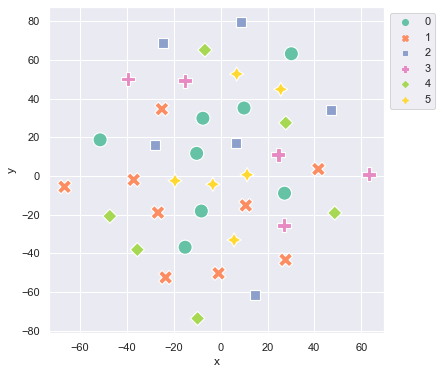

In [11]:
sns.set(style = 'darkgrid')
palette = sns.color_palette("Set2", n_colors=len(set(label)))
plt.figure(figsize=(6, 6))
pos_data = pd.DataFrame({'x':pos_z_TSNE[:,0], 'y':pos_z_TSNE[:,1], 'label':label})
sns.scatterplot(x='x', y='y', hue='label', data=pos_data, palette=palette, style="label", s=200)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.savefig(f'pos_t-SNE_k={n_nagsampling}_before')

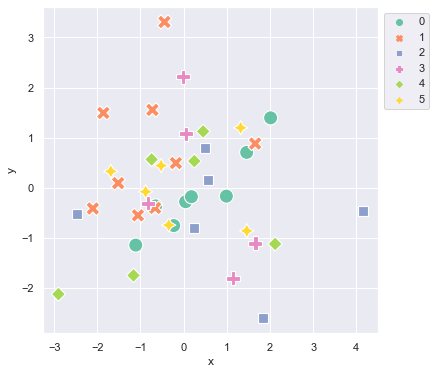

In [12]:
plt.figure(figsize=(6, 6))
pos_data = pd.DataFrame({'x':pos_z_PCA[:,0], 'y':pos_z_PCA[:,1], 'label':label})
sns.scatterplot(x='x', y='y', hue='label', data=pos_data, palette=palette, style="label", s=200)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.savefig(f'pos_PCA_k={n_nagsampling}_before')

In [13]:
epochs = tqdm(range(epoch))
pos_train_loss = []

for e in epochs:
    
    pos_optimizer.zero_grad()
    log_ps = pos_model(x_pos[:,0])
    pos_loss = pos_criterion(log_ps, x_pos[:,1])

    pos_loss.backward()
    pos_optimizer.step()
    
    pos_train_loss.append(pos_loss.item())
    epochs.set_description(f'loss: {pos_loss.item()}')

loss: 1.8124208450317383: 100%|██████████| 10000/10000 [00:21<00:00, 458.68it/s]


In [14]:
pos_w = pos_model.embed(torch.arange(len(item2idx)))
pos_z_TSNE = TSNE(n_components=2).fit_transform(pos_w.detach().numpy())
pos_z_PCA = PCA(n_components=2).fit_transform(pos_w.detach().numpy())

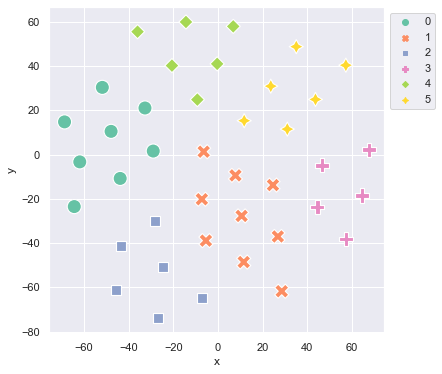

In [15]:
sns.set(style = 'darkgrid')
palette = sns.color_palette("Set2", n_colors=len(set(label)))
plt.figure(figsize=(6, 6))
pos_data = pd.DataFrame({'x':pos_z_TSNE[:,0], 'y':pos_z_TSNE[:,1], 'label':label})
sns.scatterplot(x='x', y='y', hue='label', data=pos_data, palette=palette, style="label", s=200)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.savefig(f'pos_t-SNE_k={n_nagsampling}_after')

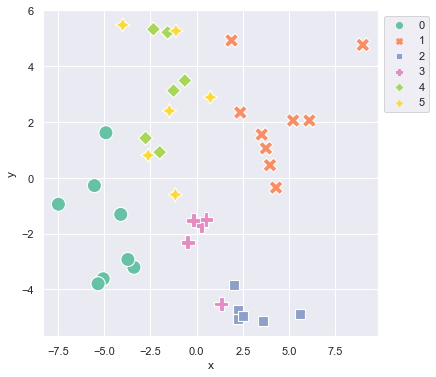

In [16]:
plt.figure(figsize=(6, 6))
pos_data = pd.DataFrame({'x':pos_z_PCA[:,0], 'y':pos_z_PCA[:,1], 'label':label})
sns.scatterplot(x='x', y='y', hue='label', data=pos_data, palette=palette, style="label", s=200)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.savefig(f'pos_PCA_k={n_nagsampling}_after')

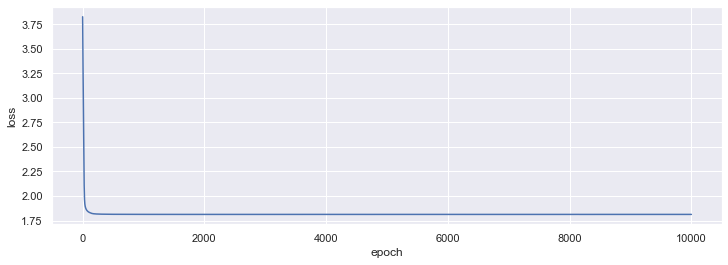

In [17]:
plt.figure(figsize=(12, 4))
sns.lineplot(data =pos_train_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(f'pos_train_loss_k={n_nagsampling}')

# Negative Sampling

In [18]:
neg_w = neg_model.forward_input(torch.arange(len(item2idx)))
neg_z_TSNE = TSNE(n_components=2).fit_transform(neg_w.detach().numpy())
neg_z_PCA = PCA(n_components=2).fit_transform(neg_w.detach().numpy())

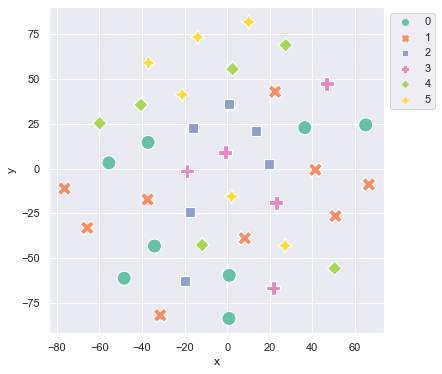

In [19]:
sns.set(style = 'darkgrid')
palette = sns.color_palette("Set2", n_colors=len(set(label)))
plt.figure(figsize=(6, 6))
neg_data = pd.DataFrame({'x':neg_z_TSNE[:,0], 'y':neg_z_TSNE[:,1], 'label':label})
sns.scatterplot(x='x', y='y', hue='label', data=neg_data, palette=palette, style="label", s=200)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.savefig(f'neg_t-SNE_k={n_nagsampling}_before')

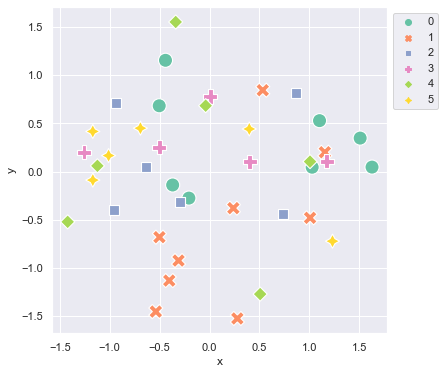

In [20]:
plt.figure(figsize=(6, 6))
neg_data = pd.DataFrame({'x':neg_z_PCA[:,0], 'y':neg_z_PCA[:,1], 'label':label})
sns.scatterplot(x='x', y='y', hue='label', data=neg_data, palette=palette, style="label", s=200)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.savefig(f'neg_PCA_k={n_nagsampling}_before')

In [21]:
epochs = tqdm(range(epoch))

neg_train_loss = []
for e in epochs:
    
    neg_optimizer.zero_grad()
    input_vectors = neg_model.forward_input(x_pos[:,0])
    output_vectors = neg_model.forward_output(x_pos[:,1])
    noise_vectors = neg_model.forward_noise(x_neg)

    neg_loss = neg_criterion(input_vectors, output_vectors, noise_vectors)

    neg_loss.backward()
    neg_optimizer.step()
    
    neg_train_loss.append(neg_loss.item())
    epochs.set_description(f'loss: {neg_loss.item()}')

loss: 4.46149570052512e-05: 100%|██████████| 10000/10000 [02:20<00:00, 71.33it/s] 


In [22]:
neg_w = neg_model.forward_input(torch.arange(len(item2idx)))
neg_z_TSNE = TSNE(n_components=2).fit_transform(neg_w.detach().numpy())
neg_z_PCA = PCA(n_components=2).fit_transform(neg_w.detach().numpy())

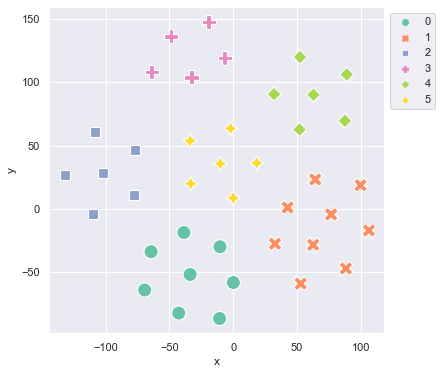

In [23]:
sns.set(style = 'darkgrid')
palette = sns.color_palette("Set2", n_colors=len(set(label)))
plt.figure(figsize=(6, 6))
neg_data = pd.DataFrame({'x':neg_z_TSNE[:,0], 'y':neg_z_TSNE[:,1], 'label':label})
sns.scatterplot(x='x', y='y', hue='label', data=neg_data, palette=palette, style="label", s=200)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.savefig(f'neg_t-SNE_k={n_nagsampling}_after')

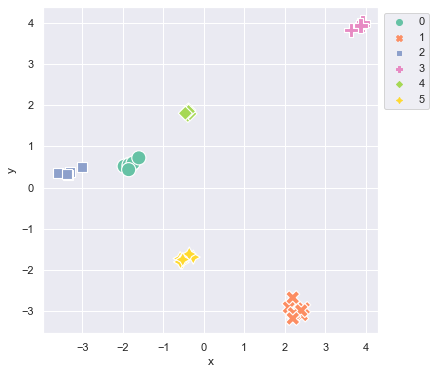

In [24]:
plt.figure(figsize=(6, 6))
neg_data = pd.DataFrame({'x':neg_z_PCA[:,0], 'y':neg_z_PCA[:,1], 'label':label})
sns.scatterplot(x='x', y='y', hue='label', data=neg_data, palette=palette, style="label", s=200)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.savefig(f'neg_PCA_k={n_nagsampling}_after')

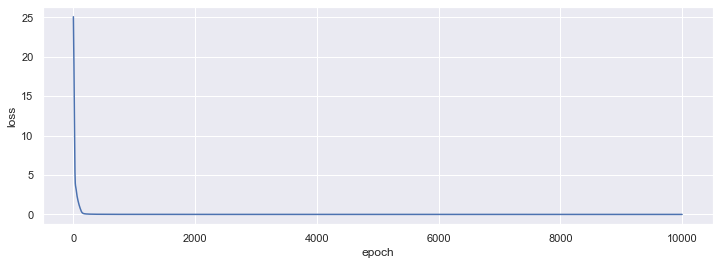

In [25]:
plt.figure(figsize=(12, 4))
sns.lineplot(data =neg_train_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(f'neg_train_loss_k={n_nagsampling}')

In [26]:
len(item2idx)

40